# Pipeline de Inferencia - Predicción de Demanda Eléctrica

Este notebook genera predicciones de demanda eléctrica para un rango de fechas específico, replicando el proceso completo de NB01→NB02→NB03.

**Flujo**:
1. **Carga**: Lee datos desde `data/*/data_parquet_clean/`
2. **Integración**: Merge de todas las fuentes (REE, meteo, precios, embalses, eventos)
3. **Feature Engineering**: Aplica transformaciones exactas de NB02:
   - Features temporales cíclicas
   - Lags (1h, 24h, 48h, 168h)
   - Medias móviles y desviaciones (6h, 12h, 24h, 48h, 168h)
   - Agregación ponderada de datos meteorológicos
4. **Predicción**: Usa modelo reentrenado de `app/models/demanda.pkl`
5. **Output**: Guarda en `app/data/demanda.csv` + `demanda.parquet`

**Columnas de salida**:
- `datetime`: Fecha y hora
- `demanda_predicha`: Predicción del modelo
- `demanda_ree_prevista`: Previsión oficial de REE (si disponible)

In [1]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
import json
import joblib
from datetime import datetime, timedelta

warnings.filterwarnings('ignore')

# Configuración
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print("Pipeline de Inferencia - Predicción de Demanda")
print("="*60)

Pipeline de Inferencia - Predicción de Demanda


## 1. Configuración de Parámetros

Define el rango de fechas para el cual se generarán las predicciones.

In [2]:
# PARÁMETROS DE INFERENCIA
# Modifica estas fechas según necesites

FECHA_INICIO = pd.Timestamp('2025-09-21 00:00:00')
FECHA_FIN = pd.Timestamp('2025-10-21 23:00:00')

print(f"Rango de predicción configurado:")
print(f"  Inicio: {FECHA_INICIO}")
print(f"  Fin:    {FECHA_FIN}")
print(f"  Duración: {(FECHA_FIN - FECHA_INICIO).days + 1} días")

Rango de predicción configurado:
  Inicio: 2025-09-21 00:00:00
  Fin:    2025-10-21 23:00:00
  Duración: 31 días


## 2. Rutas de Archivos

In [3]:
# Rutas base
BASE_DIR = Path('../..')
DATA_DIR = BASE_DIR / 'data'
APP_DIR = BASE_DIR / 'app'

# Rutas de entrada (parquet_clean) - Directorios particionados
REE_CLEAN_DIR = DATA_DIR / 'ree' / 'data_parquet_clean' / 'demanda'
METEO_CLEAN_DIR = DATA_DIR / 'climatologia' / 'data_parquet_clean' / 'meteo'
PRECIO_CLEAN_DIR = DATA_DIR / 'precio_luz' / 'data_parquet_clean' / 'precios_luz'

# Rutas de salida
APP_DATOS_DIR = APP_DIR / 'data'
APP_MODELOS_DIR = APP_DIR / 'models'

# Crear directorios si no existen
APP_DATOS_DIR.mkdir(parents=True, exist_ok=True)

print("Rutas configuradas:")
print(f"  REE DIR: {REE_CLEAN_DIR}")
print(f"  Meteo DIR: {METEO_CLEAN_DIR}")
print(f"  Salida: {APP_DATOS_DIR}")

Rutas configuradas:
  REE DIR: ../../data/ree/data_parquet_clean/demanda
  Meteo DIR: ../../data/climatologia/data_parquet_clean/meteo
  Salida: ../../app/data


## 3. Cargar Datos desde Parquet Clean

Carga los datos necesarios para el rango de fechas especificado.

In [4]:
print("="*80)
print("CARGANDO DATOS DESDE PARQUET_CLEAN")
print("="*80)

print("\n1. Cargando datos de REE (Demanda)...")
print("   NOTA: Se cargarán 168h adicionales antes de FECHA_INICIO para calcular lags y medias móviles")

# Cargar con histórico: 168h antes de FECHA_INICIO para poder calcular lags
fecha_inicio_con_historico = FECHA_INICIO - pd.Timedelta(hours=168)

df_ree = pd.read_parquet(REE_CLEAN_DIR)

# REE tiene columna 'Hora' (mayúscula), necesitamos renombrarla a 'datetime'
if 'Hora' in df_ree.columns:
    df_ree = df_ree.rename(columns={'Hora': 'datetime'})
elif 'hora' in df_ree.columns:
    df_ree = df_ree.rename(columns={'hora': 'datetime'})

df_ree['datetime'] = pd.to_datetime(df_ree['datetime'])

# Filtrar por rango AMPLIADO (incluye histórico)
df_ree = df_ree[(df_ree['datetime'] >= fecha_inicio_con_historico) & (df_ree['datetime'] <= FECHA_FIN)].copy()

print(f"  Registros cargados: {len(df_ree):,}")
print(f"  Período (con histórico): {df_ree['datetime'].min()} a {df_ree['datetime'].max()}")
print(f"  Columnas: {list(df_ree.columns)}")

CARGANDO DATOS DESDE PARQUET_CLEAN

1. Cargando datos de REE (Demanda)...
   NOTA: Se cargarán 168h adicionales antes de FECHA_INICIO para calcular lags y medias móviles
  Registros cargados: 10,933
  Período (con histórico): 2025-09-14 00:00:00 a 2025-10-21 23:00:00
  Columnas: ['datetime', 'Real', 'Prevista', 'Programada', 'year']


In [5]:
print("\n2. Cargando datos meteorológicos...")
try:
    # Leer directorio particionado
    df_meteo = pd.read_parquet(METEO_CLEAN_DIR)
    
    # Meteo tiene columna 'time', renombrar a 'datetime'
    if 'time' in df_meteo.columns:
        df_meteo = df_meteo.rename(columns={'time': 'datetime'})
    elif 'Time' in df_meteo.columns:
        df_meteo = df_meteo.rename(columns={'Time': 'datetime'})
    
    df_meteo['datetime'] = pd.to_datetime(df_meteo['datetime'])
    # Usar rango AMPLIADO (con histórico)
    df_meteo = df_meteo[(df_meteo['datetime'] >= fecha_inicio_con_historico) & (df_meteo['datetime'] <= FECHA_FIN)]
    
    print(f"  Registros cargados: {len(df_meteo):,}")
except Exception as e:
    print(f"  ADVERTENCIA: No se pudieron cargar datos meteorológicos: {e}")
    df_meteo = pd.DataFrame()


2. Cargando datos meteorológicos...
  Registros cargados: 38,640


In [6]:
print("\n3. Cargando datos de precio de luz...")
try:
    df_precio = pd.read_parquet(PRECIO_CLEAN_DIR)
    
    # Normalizar nombre de columna temporal
    if 'time' in df_precio.columns:
        df_precio = df_precio.rename(columns={'time': 'datetime'})
    elif 'Hora' in df_precio.columns:
        df_precio = df_precio.rename(columns={'Hora': 'datetime'})
    elif 'hora' in df_precio.columns:
        df_precio = df_precio.rename(columns={'hora': 'datetime'})
    
    df_precio['datetime'] = pd.to_datetime(df_precio['datetime'])
    # Usar rango AMPLIADO (con histórico)
    df_precio = df_precio[(df_precio['datetime'] >= fecha_inicio_con_historico) & (df_precio['datetime'] <= FECHA_FIN)].copy()
    print(f"  Registros cargados: {len(df_precio):,}")
except Exception as e:
    print(f"  ADVERTENCIA: No se pudieron cargar datos de precio: {e}")
    df_precio = pd.DataFrame()


3. Cargando datos de precio de luz...
  Registros cargados: 912


## 4. Integración de Datos

Combina todas las fuentes de datos en un único DataFrame.

In [7]:
print("\n" + "="*80)
print("INTEGRACIÓN DE DATOS")
print("="*80)

# Merge base: REE
print("\nIntegrando datos...")
df = df_ree.copy()
print(f"  Base (REE): {df.shape}")
print(f"  Columnas REE: {list(df.columns)}")

# Merge con meteo (si existe)
if not df_meteo.empty:
    print(f"\n  Columnas meteo disponibles: {list(df_meteo.columns)}")
    
    # Identificar columnas meteorológicas a usar
    # Pueden estar en formato: temperature_2m, precipitation, wind_speed_10m, etc.
    columnas_meteo_posibles = ['temperature_2m', 'precipitation', 'rain', 'cloud_cover', 
                               'wind_speed_10m', 'wind_direction_10m', 'wind_gusts_10m']
    
    columnas_meteo_disponibles = [col for col in columnas_meteo_posibles if col in df_meteo.columns]
    
    if columnas_meteo_disponibles:
        print(f"  Columnas meteorológicas a agregar: {columnas_meteo_disponibles}")
        
        # Si hay columna 'city' o 'ciudad', necesitamos agregar por datetime
        if 'city' in df_meteo.columns or 'ciudad' in df_meteo.columns:
            print("  Agregando datos meteorológicos por promedio...")
            df_meteo_agg = df_meteo.groupby('datetime')[columnas_meteo_disponibles].mean().reset_index()
        else:
            # Si no hay ciudad, usar directamente
            df_meteo_agg = df_meteo[['datetime'] + columnas_meteo_disponibles].copy()
        
        df = df.merge(df_meteo_agg, on='datetime', how='left')
        print(f"  Después de meteo: {df.shape}")
    else:
        print("  ADVERTENCIA: No se encontraron columnas meteorológicas estándar")
else:
    print("  Sin datos meteorológicos")

# Merge con precio
if not df_precio.empty:
    print(f"\n  Columnas precio: {list(df_precio.columns)}")
    df = df.merge(df_precio, on='datetime', how='left', suffixes=('', '_precio'))
    print(f"  Después de precio: {df.shape}")
else:
    print("  Sin datos de precio")

print(f"\nDataFrame integrado: {df.shape}")
print(f"Columnas finales: {list(df.columns)}")
print("="*80)


INTEGRACIÓN DE DATOS

Integrando datos...
  Base (REE): (10933, 5)
  Columnas REE: ['datetime', 'Real', 'Prevista', 'Programada', 'year']

  Columnas meteo disponibles: ['datetime', 'temperature_2m', 'precipitation', 'rain', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high', 'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m', 'wind_direction_100m', 'wind_gusts_10m', 'date', 'hour', 'latitude', 'longitude', 'generationtime_ms', 'utc_offset_seconds', 'timezone', 'timezone_abbreviation', 'elevation', 'city', 'year']
  Columnas meteorológicas a agregar: ['temperature_2m', 'precipitation', 'rain', 'cloud_cover', 'wind_speed_10m', 'wind_direction_10m', 'wind_gusts_10m']
  Agregando datos meteorológicos por promedio...
  Después de meteo: (10933, 12)

  Columnas precio: ['datetime', 'Dia', 'GEN', 'NOC', 'VHC', 'COFGEN', 'COFNOC', 'COFVHC', 'PMHGEN', 'PMHNOC', 'PMHVHC', 'SAHGEN', 'SAHNOC', 'SAHVHC', 'FOMGEN', 'FOMNOC', 'FOMVHC', 'FOSGEN', 'FOSNOC', 'FOSVHC', 'INTG

In [8]:
import warnings
import numpy as np
warnings.filterwarnings('ignore')

def estandarizar_frecuencia_horaria(df, columnas_numericas, metodo='mean'):
    """
    Estandariza un dataframe a frecuencia horaria sin huecos ni duplicados.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame con columna 'datetime'
    columnas_numericas : list
        Lista de columnas numéricas a procesar
    metodo : str
        'mean' (agregación por media), 'ffill' (forward fill), 'interpolate' (interpolación lineal)
    
    Returns:
    --------
    pd.DataFrame estandarizado a frecuencia horaria
    """
    # 1. Ordenar por datetime
    df = df.sort_values('datetime').copy()
    
    # 2. Asegurar que datetime esté en formato datetime
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # 3. Redondear a la hora más cercana (por si hay segundos/minutos)
    df['datetime'] = df['datetime'].dt.floor('H')
    
    # 4. Eliminar duplicados según el método
    if metodo == 'mean':
        # Agrupar por hora y promediar
        df_grouped = df.groupby('datetime')[columnas_numericas].mean().reset_index()
    elif metodo == 'ffill':
        # Tomar el primer valor de cada hora (mantener solo datetime y columnas numéricas)
        df_temp = df[['datetime'] + columnas_numericas].copy()
        df_grouped = df_temp.drop_duplicates(subset='datetime', keep='first').reset_index(drop=True)
    elif metodo == 'interpolate':
        # Eliminar duplicados tomando la media
        df_grouped = df.groupby('datetime')[columnas_numericas].mean().reset_index()
    else:
        raise ValueError(f"Método '{metodo}' no reconocido")
    
    # 5. Crear rango completo de horas (sin huecos)
    fecha_min = df_grouped['datetime'].min()
    fecha_max = df_grouped['datetime'].max()
    rango_completo = pd.date_range(start=fecha_min, end=fecha_max, freq='H')
    
    # 6. Reindexar para llenar huecos
    df_estandarizado = df_grouped.set_index('datetime').reindex(rango_completo)
    
    # 7. Rellenar huecos según el método
    if metodo == 'mean' or metodo == 'interpolate':
        # Interpolación lineal para valores continuos
        df_estandarizado[columnas_numericas] = df_estandarizado[columnas_numericas].interpolate(method='linear', limit_direction='both')
    elif metodo == 'ffill':
        # Forward fill para valores discretos (como niveles de embalse)
        df_estandarizado[columnas_numericas] = df_estandarizado[columnas_numericas].ffill()
        # Si quedan NaN al inicio, usar backfill
        df_estandarizado[columnas_numericas] = df_estandarizado[columnas_numericas].bfill()
    
    # 8. Resetear índice
    df_estandarizado.index.name = 'datetime'
    df_estandarizado = df_estandarizado.reset_index()
    
    return df_estandarizado

print("Función de estandarización definida correctamente")

Función de estandarización definida correctamente


In [9]:
print("\n" + "="*80)
print("ESTANDARIZANDO TODOS LOS DATASETS A FRECUENCIA HORARIA")
print("="*80)

# 1. DEMANDA: Agregación de 5min a 1 hora usando media
print("\n1. Procesando DEMANDA (5min → 1h)...")
print(f"   Registros antes: {len(df):,}")

# Identificar columnas numéricas (excluyendo datetime y columnas categóricas)
demand_cols = [col for col in df.columns 
               if col not in ['datetime', 'ambito_nombre', 'ambito_id'] 
               and df[col].dtype in ['float64', 'int64', 'float32', 'int32']]
print(f"   Columnas a procesar: {demand_cols}")

df = estandarizar_frecuencia_horaria(
    df, 
    columnas_numericas=demand_cols,
    metodo='mean'  # Media para agregar de 5min a 1h
)
print(f"   Registros después: {len(df):,}")
print(f"   Frecuencia: {df['datetime'].diff().mode()[0]}")

# 2. METEOROLOGÍA: Ya debería ser horaria, solo rellenar huecos
print("\n2. Procesando METEOROLOGÍA (1h → 1h)...")
print(f"   Registros antes: {len(df_meteo):,}")

# Identificar columnas numéricas (excluyendo categóricas)
weather_cols = [col for col in df_meteo.columns 
                if col != 'datetime' 
                and df_meteo[col].dtype in ['float64', 'int64', 'float32', 'int32']]
print(f"   Columnas a procesar: {len(weather_cols)} variables meteorológicas")

df_meteo = estandarizar_frecuencia_horaria(
    df_meteo,
    columnas_numericas=weather_cols,
    metodo='interpolate'  # Interpolación lineal para variables continuas
)
print(f"   Registros después: {len(df_meteo):,}")
print(f"   Frecuencia: {df_meteo['datetime'].diff().mode()[0]}")

# 3. PRECIOS: Horaria, eliminar duplicados y rellenar huecos
print("\n3. Procesando PRECIOS (1h → 1h)...")
print(f"   Registros antes: {len(df_precio):,}")

price_cols = ['price']

df_precio = estandarizar_frecuencia_horaria(
    df_precio,
    columnas_numericas=price_cols,
    metodo='mean'  # Media en caso de duplicados
)
print(f"   Registros después: {len(df_precio):,}")
print(f"   Frecuencia: {df_precio['datetime'].diff().mode()[0]}")


print("\n" + "="*80)
print("ESTANDARIZACIÓN COMPLETADA")
print("="*80)
print("\nTodos los datasets ahora tienen:")
print("  ✓ Frecuencia horaria (1H)")
print("  ✓ Sin huecos temporales")
print("  ✓ Sin duplicados")
print("  ✓ Mismo rango de fechas alineado")


ESTANDARIZANDO TODOS LOS DATASETS A FRECUENCIA HORARIA

1. Procesando DEMANDA (5min → 1h)...
   Registros antes: 10,933
   Columnas a procesar: ['Real', 'Prevista', 'Programada', 'temperature_2m', 'precipitation', 'rain', 'cloud_cover', 'wind_speed_10m', 'wind_direction_10m', 'wind_gusts_10m', 'GEN', 'NOC', 'VHC', 'COFGEN', 'COFNOC', 'COFVHC', 'PMHGEN', 'PMHNOC', 'PMHVHC', 'SAHGEN', 'SAHNOC', 'SAHVHC', 'FOMGEN', 'FOMNOC', 'FOMVHC', 'FOSGEN', 'FOSNOC', 'FOSVHC', 'INTGEN', 'INTNOC', 'INTVHC', 'PCAPGEN', 'PCAPNOC', 'PCAPVHC', 'TEUGEN', 'TEUNOC', 'TEUVHC', 'CCVGEN', 'CCVNOC', 'CCVVHC', 'price', 'PCB', 'CYM', 'COF2TD', 'PMHPCB', 'PMHCYM', 'SAHPCB', 'SAHCYM', 'FOMPCB', 'FOMCYM', 'FOSPCB', 'FOSCYM', 'INTPCB', 'INTCYM', 'PCAPPCB', 'PCAPCYM', 'TEUPCB', 'TEUCYM', 'CCVPCB', 'CCVCYM', 'EDSRPCB', 'EDSRCYM', 'EDCGASPCB', 'EDCGASCYM', 'TAHPCB', 'TAHCYM']
   Registros después: 912
   Frecuencia: 0 days 01:00:00

2. Procesando METEOROLOGÍA (1h → 1h)...
   Registros antes: 38,640
   Columnas a procesar

## 5. Feature Engineering

Aplica las mismas transformaciones que en entrenamiento.

In [10]:
print("\n" + "="*80)
print("FEATURE ENGINEERING (IGUAL QUE NB02)")
print("="*80)

# Asegurar orden temporal
df = df.sort_values('datetime').reset_index(drop=True)

# 1. Features temporales cíclicas
print("\n1. Creando features temporales cíclicas...")
df['hora_del_dia_sin'] = np.sin(2 * np.pi * df['datetime'].dt.hour/24)
df['hora_del_dia_cos'] = np.cos(2 * np.pi * df['datetime'].dt.hour/24)
df['dia_semana_sin'] = np.sin(2 * np.pi * df['datetime'].dt.dayofweek/7)
df['dia_semana_cos'] = np.cos(2 * np.pi * df['datetime'].dt.dayofweek/7)
df['mes_sin'] = np.sin(2 * np.pi * df['datetime'].dt.month/12)
df['mes_cos'] = np.cos(2 * np.pi * df['datetime'].dt.month/12)

# 2. Features categóricas
print("2. Creando features categóricas...")
df['hora_del_dia'] = df['datetime'].dt.hour
df['dia_semana'] = df['datetime'].dt.dayofweek
df['mes'] = df['datetime'].dt.month
df['trimestre'] = df['datetime'].dt.quarter
df['año'] = df['datetime'].dt.year

# 3. Festivos
print("3. Detectando festivos...")
import holidays
df['es_festivo'] = df['datetime'].dt.date.isin(
    holidays.Spain(years=df['datetime'].dt.year.unique().tolist())
).astype(int)

# 4. Features binarias
print("4. Creando features binarias...")
df['es_finde'] = df['dia_semana'].isin([5, 6]).astype(int)
df['es_laboral'] = (~df['dia_semana'].isin([5, 6])).astype(int)
df['es_hora_pico_mañana'] = df['hora_del_dia'].between(7, 9).astype(int)
df['es_hora_pico_tarde'] = df['hora_del_dia'].between(18, 20).astype(int)

print(f"\nFeatures temporales creadas: {df.shape}")
print("="*80)


FEATURE ENGINEERING (IGUAL QUE NB02)

1. Creando features temporales cíclicas...
2. Creando features categóricas...
3. Detectando festivos...
4. Creando features binarias...

Features temporales creadas: (912, 83)


## 5b. Lags y Medias Móviles

**CRÍTICO**: Para generar predicciones, necesitamos los valores históricos recientes de demanda para crear lags y medias móviles. 

**Estrategia**:
- Si existe `demanda` o `real` en el dataset → usar esos valores históricos


In [11]:
print("\n" + "="*80)
print("LAGS Y MEDIAS MÓVILES (IGUAL QUE NB02)")
print("="*80)

# Determinar columna target
print(f"\nColumnas disponibles en df: {list(df.columns)}")

if 'demanda' in df.columns:
    columna_target = 'demanda'
elif 'real' in df.columns:
    columna_target = 'real'
else:
    # Buscar columnas que puedan contener la demanda
    posibles_columnas = [col for col in df.columns if 'demanda' in col.lower() or 'real' in col.lower()]
    if posibles_columnas:
        columna_target = posibles_columnas[0]
        print(f"ADVERTENCIA: Usando columna '{columna_target}' como target")
    else:
        print(f"\nERROR: Columnas disponibles: {list(df.columns)}")
        raise ValueError("No se encontró columna de demanda en el dataset. Columnas disponibles: " + str(list(df.columns)))

print(f"\nUsando columna target: '{columna_target}'")

# Crear lags (1h, 24h, 48h, 168h)
print("\n5. Creando lags...")
lags = [1, 24, 48, 168]
for lag in lags:
    df[f'lag_{lag}h'] = df[columna_target].shift(lag)
    
print(f"   Lags creados: {lags}")

# Crear medias móviles y desviaciones
print("\n6. Creando medias móviles y desviaciones...")
ventanas = [6, 12, 24, 48, 168]
for ventana in ventanas:
    df[f'media_movil_{ventana}h'] = df[columna_target].rolling(window=ventana).mean()
    df[f'std_movil_{ventana}h'] = df[columna_target].rolling(window=ventana).std()
    
print(f"   Ventanas: {ventanas}")

# IMPORTANTE: Filtrar para quedarnos solo con el rango solicitado (eliminar histórico)
print(f"\n7. Filtrando al rango solicitado...")
print(f"   Dataset antes del filtro: {len(df)} registros")
df = df[df['datetime'] >= FECHA_INICIO].reset_index(drop=True)
print(f"   Dataset después del filtro: {len(df)} registros")

print(f"\nDataset final después de lags/MA: {df.shape}")
print(f"  Período: {df['datetime'].min()} a {df['datetime'].max()}")

# Renombrar columna target a 'demanda' si no lo es
if columna_target != 'demanda' and columna_target in df.columns:
    df = df.rename(columns={columna_target: 'demanda'})

print("="*80)


LAGS Y MEDIAS MÓVILES (IGUAL QUE NB02)

Columnas disponibles en df: ['datetime', 'Real', 'Prevista', 'Programada', 'temperature_2m', 'precipitation', 'rain', 'cloud_cover', 'wind_speed_10m', 'wind_direction_10m', 'wind_gusts_10m', 'GEN', 'NOC', 'VHC', 'COFGEN', 'COFNOC', 'COFVHC', 'PMHGEN', 'PMHNOC', 'PMHVHC', 'SAHGEN', 'SAHNOC', 'SAHVHC', 'FOMGEN', 'FOMNOC', 'FOMVHC', 'FOSGEN', 'FOSNOC', 'FOSVHC', 'INTGEN', 'INTNOC', 'INTVHC', 'PCAPGEN', 'PCAPNOC', 'PCAPVHC', 'TEUGEN', 'TEUNOC', 'TEUVHC', 'CCVGEN', 'CCVNOC', 'CCVVHC', 'price', 'PCB', 'CYM', 'COF2TD', 'PMHPCB', 'PMHCYM', 'SAHPCB', 'SAHCYM', 'FOMPCB', 'FOMCYM', 'FOSPCB', 'FOSCYM', 'INTPCB', 'INTCYM', 'PCAPPCB', 'PCAPCYM', 'TEUPCB', 'TEUCYM', 'CCVPCB', 'CCVCYM', 'EDSRPCB', 'EDSRCYM', 'EDCGASPCB', 'EDCGASCYM', 'TAHPCB', 'TAHCYM', 'hora_del_dia_sin', 'hora_del_dia_cos', 'dia_semana_sin', 'dia_semana_cos', 'mes_sin', 'mes_cos', 'hora_del_dia', 'dia_semana', 'mes', 'trimestre', 'año', 'es_festivo', 'es_finde', 'es_laboral', 'es_hora_pico_ma

## 6. Cargar Features Seleccionadas y Modelo

In [12]:
print("\n" + "="*80)
print("CARGAR MODELO REENTRENADO")
print("="*80)

# Buscar modelo en app/models/
model_path = APP_MODELOS_DIR / 'demanda.pkl'

if not model_path.exists():
    raise FileNotFoundError(
        f"No se encontró modelo en {model_path}\\n"
        f"Ejecuta el notebook 08_model_comparison.ipynb para entrenar y guardar el modelo."
    )

print(f"\nCargando modelo desde: {model_path}")
pipeline = joblib.load(model_path)

print("✓ Modelo cargado correctamente")
print(f"  Tipo: {type(pipeline).__name__}")

# El pipeline tiene internamente las features que necesita
if hasattr(pipeline, 'feature_names_in_'):
    required_features = pipeline.feature_names_in_
    print(f"  Features requeridas: {len(required_features)}")
else:
    raise ValueError("El modelo no tiene feature_names_in_. Puede ser un modelo antiguo.")

print("="*80)


CARGAR MODELO REENTRENADO

Cargando modelo desde: ../../app/models/demanda.pkl
✓ Modelo cargado correctamente
  Tipo: Pipeline
  Features requeridas: 29


## 7. Preparar Datos para Predicción

In [13]:
print("\n" + "="*80)
print("PREPARAR DATOS PARA PREDICCIÓN")
print("="*80)

# Verificar features disponibles vs requeridas
available_features = [f for f in required_features if f in df.columns]
missing_features = [f for f in required_features if f not in df.columns]

print(f"\nFeatures requeridas: {len(required_features)}")
print(f"Features disponibles: {len(available_features)}")
print(f"Features faltantes: {len(missing_features)}")

if missing_features:
    print(f"\nERROR: Faltan {len(missing_features)} features:")
    for feat in missing_features[:20]:
        print(f"  - {feat}")
    if len(missing_features) > 20:
        print(f"  ... y {len(missing_features) - 20} más")
    
    raise ValueError(
        f"Faltan {len(missing_features)} features requeridas por el modelo.\\n"
        "Verifica que las transformaciones de Feature Engineering sean idénticas a NB02."
    )

# Preparar matriz X con SOLO las features que el modelo necesita, en el ORDEN correcto
X = df[required_features].copy()

# Manejar valores NaN
nan_count = X.isna().sum().sum()
if nan_count > 0:
    print(f"\nADVERTENCIA: {nan_count} valores NaN detectados")
    print("  Aplicando forward fill + backward fill + 0")
    X = X.fillna(method='ffill').fillna(method='bfill').fillna(0)

print(f"\nDatos preparados para predicción:")
print(f"  Shape: {X.shape}")
print(f"  Registros: {len(X):,}")
print(f"  Features: {len(required_features)}")

# Guardar datetime para el output
dates_output = df['datetime'].values

print("="*80)


PREPARAR DATOS PARA PREDICCIÓN

Features requeridas: 29
Features disponibles: 29
Features faltantes: 0

Datos preparados para predicción:
  Shape: (744, 29)
  Registros: 744
  Features: 29


## 8. Generar Predicciones

In [14]:
print("\n" + "="*80)
print("GENERAR PREDICCIONES")
print("="*80)

print("\nRealizando predicciones con el pipeline...")
predictions = pipeline.predict(X)

# Si es array 2D, aplanar
if len(predictions.shape) > 1:
    predictions = predictions.flatten()

print(f"\n✓ Predicciones generadas: {len(predictions):,}")
print(f"  Rango: {predictions.min():.2f} - {predictions.max():.2f} MW")
print(f"  Media: {predictions.mean():.2f} MW")
print(f"  Mediana: {np.median(predictions):.2f} MW")

print("="*80)


GENERAR PREDICCIONES

Realizando predicciones con el pipeline...

✓ Predicciones generadas: 744
  Rango: 19458.46 - 33604.06 MW
  Media: 27118.02 MW
  Mediana: 27748.19 MW


## 9. Crear DataFrame de Salida

In [15]:
print("\n" + "="*80)
print("CREAR DATAFRAME DE SALIDA")
print("="*80)

# Buscar columna de demanda real
demanda_real = None
if 'real' in df.columns:
    demanda_real = df['real'].values
    print("✓ Demanda real encontrada: 'real'")
elif 'demanda' in df.columns:
    demanda_real = df['demanda'].values
    print("✓ Demanda real encontrada: 'demanda'")
else:
    print("  Sin demanda real disponible")

# Buscar columna de previsión de REE si existe
demanda_ree_prevista = None
if 'prevista' in df.columns:
    demanda_ree_prevista = df['prevista'].values
    print("✓ Previsión REE encontrada: 'prevista'")
elif 'demanda_prevista' in df.columns:
    demanda_ree_prevista = df['demanda_prevista'].values
    print("✓ Previsión REE encontrada: 'demanda_prevista'")
elif 'prevision' in df.columns:
    demanda_ree_prevista = df['prevision'].values
    print("✓ Previsión REE encontrada: 'prevision'")
else:
    prev_cols = [col for col in df.columns if 'prev' in col.lower()]
    if prev_cols:
        demanda_ree_prevista = df[prev_cols[0]].values
        print(f"✓ Previsión REE encontrada: '{prev_cols[0]}'")
    else:
        print("  Sin previsión de REE disponible")

# Crear DataFrame de salida con formato requerido:
# datetime, demanda_real, demanda_prevista_ree, demanda_prevista_modelo
df_output = pd.DataFrame({
    'datetime': dates_output,
    'demanda_real': demanda_real if demanda_real is not None else np.nan,
    'demanda_prevista_ree': demanda_ree_prevista if demanda_ree_prevista is not None else np.nan,
    'demanda_prevista_modelo': predictions
})

# Extraer día y hora por separado para formato más legible
df_output['dia'] = df_output['datetime'].dt.date
df_output['hora'] = df_output['datetime'].dt.hour

# Reordenar columnas: dia, hora, demanda_real, demanda_prevista_ree, demanda_prevista_modelo
df_output = df_output[['dia', 'hora', 'datetime', 'demanda_real', 'demanda_prevista_ree', 'demanda_prevista_modelo']]

print(f"\nDataFrame de salida:")
print(f"  Registros: {len(df_output):,}")
print(f"  Columnas: {list(df_output.columns)}")
print(f"\nPrimeras 10 filas:")
print(df_output.head(10))

print("="*80)


CREAR DATAFRAME DE SALIDA
✓ Demanda real encontrada: 'demanda'
✓ Previsión REE encontrada: 'Prevista'

DataFrame de salida:
  Registros: 744
  Columnas: ['dia', 'hora', 'datetime', 'demanda_real', 'demanda_prevista_ree', 'demanda_prevista_modelo']

Primeras 10 filas:
          dia  hora            datetime  demanda_real  demanda_prevista_ree  \
0  2025-09-21     0 2025-09-21 00:00:00     26328.083             25915.000   
1  2025-09-21     1 2025-09-21 01:00:00     24969.583             24426.417   
2  2025-09-21     2 2025-09-21 02:00:00     23757.000             23319.917   
3  2025-09-21     3 2025-09-21 03:00:00     23061.000             22555.833   
4  2025-09-21     4 2025-09-21 04:00:00     22461.250             22409.000   
5  2025-09-21     5 2025-09-21 05:00:00     22240.333             22271.250   
6  2025-09-21     6 2025-09-21 06:00:00     22475.250             22570.917   
7  2025-09-21     7 2025-09-21 07:00:00     23056.333             23113.667   
8  2025-09-21     8 

## 10. Guardar Resultados

In [16]:
print("\n" + "="*80)
print("GUARDAR RESULTADOS")
print("="*80)

# Ruta del archivo CSV principal
output_csv = APP_DATOS_DIR / 'demanda.csv'

# Verificar si existe archivo previo (histórico)
if output_csv.exists():
    print(f"\nArchivo existente encontrado: {output_csv}")
    df_existente = pd.read_csv(output_csv)
    df_existente['datetime'] = pd.to_datetime(df_existente['datetime'])
    
    print(f"Registros existentes: {len(df_existente):,}")
    print(f"Período existente: {df_existente['datetime'].min()} a {df_existente['datetime'].max()}")
    
    # Concatenar predicciones nuevas con histórico
    print(f"\nAñadiendo predicciones al archivo existente...")
    df_combined = pd.concat([df_existente, df_output], ignore_index=True)
    
    # Eliminar duplicados (mantener el más reciente - las predicciones nuevas)
    registros_antes = len(df_combined)
    df_combined = df_combined.drop_duplicates(subset='datetime', keep='last')
    duplicados = registros_antes - len(df_combined)
    if duplicados > 0:
        print(f"Se actualizaron {duplicados:,} registros existentes")
    
    # Ordenar por datetime
    df_combined = df_combined.sort_values('datetime').reset_index(drop=True)
    
    # Recalcular dia y hora
    df_combined['dia'] = df_combined['datetime'].dt.date
    df_combined['hora'] = df_combined['datetime'].dt.hour
    
    # Reordenar columnas
    df_combined = df_combined[['dia', 'hora', 'datetime', 'demanda_real', 'demanda_prevista_ree', 'demanda_prevista_modelo']]
    
    print(f"\nDatos combinados:")
    print(f"Total de registros: {len(df_combined):,}")
    print(f"Período completo: {df_combined['datetime'].min()} a {df_combined['datetime'].max()}")
    
    # Guardar archivo combinado
    df_combined.to_csv(output_csv, index=False)
    print(f"\nCSV actualizado: {output_csv}")
    
    df_final = df_combined
    
else:
    print(f"\nNo existe archivo previo. Creando nuevo archivo...")
    df_output.to_csv(output_csv, index=False)
    print(f"CSV guardado: {output_csv}")
    
    df_final = df_output


# Estadísticas de las NUEVAS predicciones generadas
print(f"\nPredicciones generadas:")
print(f"Registros nuevos: {len(df_output):,}")
print(f"Período: {df_output['datetime'].min()} a {df_output['datetime'].max()}")
print(f"Promedio: {df_output['demanda_prevista_modelo'].mean():.2f} MW | Min: {df_output['demanda_prevista_modelo'].min():.2f} | Max: {df_output['demanda_prevista_modelo'].max():.2f}")

# Comparación si hay datos reales
if not df_output['demanda_real'].isna().all():
    mae_real = (df_output['demanda_prevista_modelo'] - df_output['demanda_real']).abs().mean()
    print(f"MAE vs demanda real: {mae_real:.2f} MW")

# Comparación con previsión REE
if not df_output['demanda_prevista_ree'].isna().all():
    diff = (df_output['demanda_prevista_modelo'] - df_output['demanda_prevista_ree']).abs().mean()
    print(f"MAE vs previsión REE: {diff:.2f} MW")

print(f"\nArchivo final: {output_csv}")
print(f"Registros totales: {len(df_final):,}")
print(f"Período completo: {df_final['datetime'].min()} a {df_final['datetime'].max()}")
print("="*80)


GUARDAR RESULTADOS

Archivo existente encontrado: ../../app/data/demanda.csv
Registros existentes: 744
Período existente: 2025-09-21 00:00:00 a 2025-10-21 23:00:00

Añadiendo predicciones al archivo existente...
Se actualizaron 744 registros existentes

Datos combinados:
Total de registros: 744
Período completo: 2025-09-21 00:00:00 a 2025-10-21 23:00:00

CSV actualizado: ../../app/data/demanda.csv

Predicciones generadas:
Registros nuevos: 744
Período: 2025-09-21 00:00:00 a 2025-10-21 23:00:00
Promedio: 27118.02 MW | Min: 19458.46 | Max: 33604.06
MAE vs demanda real: 271.31 MW
MAE vs previsión REE: 270.85 MW

Archivo final: ../../app/data/demanda.csv
Registros totales: 744
Período completo: 2025-09-21 00:00:00 a 2025-10-21 23:00:00


## 11. Visualización (Opcional)

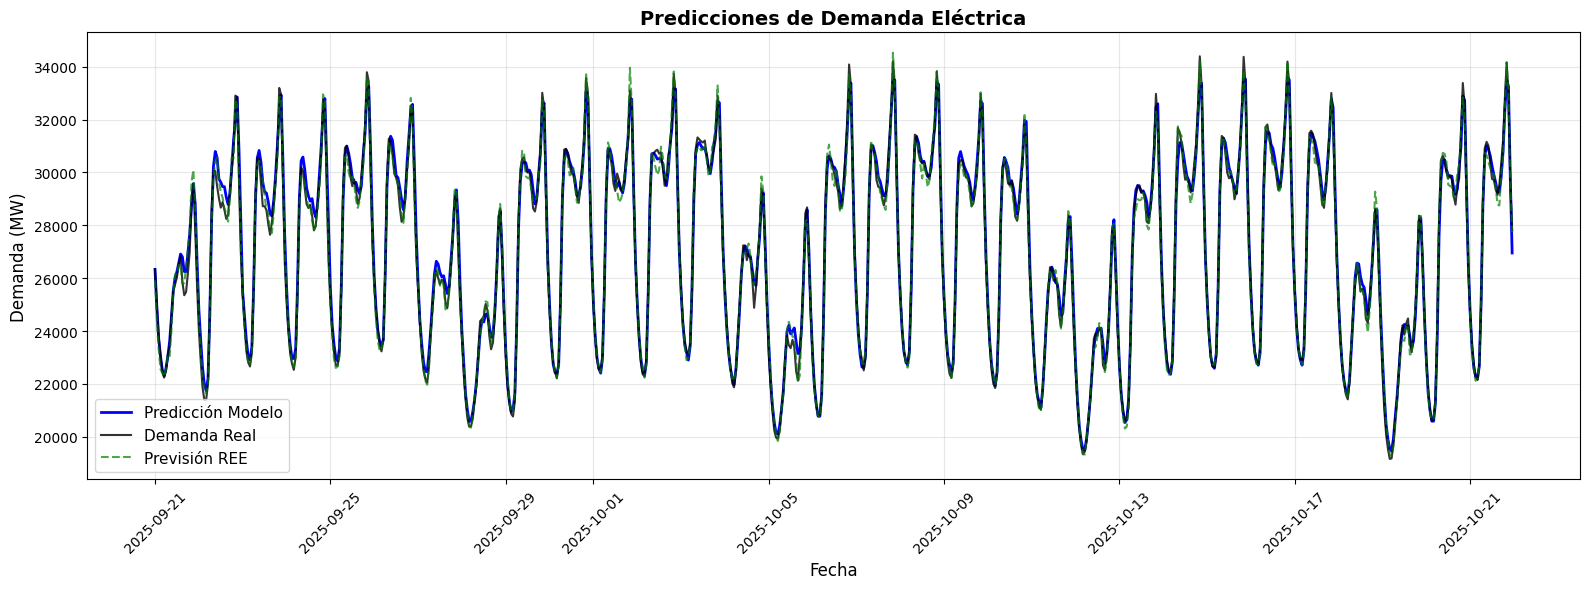


Visualización completada


In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 6))

# Predicción del modelo (línea principal)
ax.plot(df_output['datetime'], df_output['demanda_prevista_modelo'], 
        label='Predicción Modelo', color='blue', linewidth=2)

# Demanda real (si existe)
if not df_output['demanda_real'].isna().all():
    ax.plot(df_output['datetime'], df_output['demanda_real'], 
            label='Demanda Real', color='black', linewidth=1.5, alpha=0.8)

# Previsión REE (si existe)
if not df_output['demanda_prevista_ree'].isna().all():
    ax.plot(df_output['datetime'], df_output['demanda_prevista_ree'], 
            label='Previsión REE', color='green', linewidth=1.5, alpha=0.7, linestyle='--')

ax.set_title('Predicciones de Demanda Eléctrica', fontsize=14, fontweight='bold')
ax.set_xlabel('Fecha', fontsize=12)
ax.set_ylabel('Demanda (MW)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nVisualización completada")

## 12. Estadísticas Finales

In [18]:
print("\n" + "="*80)
print("ESTADÍSTICAS FINALES")
print("="*80)

print("\nResumen estadístico de las predicciones:")
print(df_output[['demanda_real', 'demanda_prevista_ree', 'demanda_prevista_modelo']].describe())

# Comparación con demanda real
if not df_output['demanda_real'].isna().all():
    print("\n" + "-"*80)
    print("COMPARACIÓN CON DEMANDA REAL")
    print("-"*80)
    
    # Error del modelo
    error_modelo = df_output['demanda_prevista_modelo'] - df_output['demanda_real']
    mae_modelo = error_modelo.abs().mean()
    rmse_modelo = np.sqrt((error_modelo ** 2).mean())
    
    print(f"\nModelo predictivo:")
    print(f"  MAE:  {mae_modelo:.2f} MW")
    print(f"  RMSE: {rmse_modelo:.2f} MW")
    print(f"  Error medio: {error_modelo.mean():.2f} MW")
    
    # Error de REE (si existe)
    if not df_output['demanda_prevista_ree'].isna().all():
        error_ree = df_output['demanda_prevista_ree'] - df_output['demanda_real']
        mae_ree = error_ree.abs().mean()
        rmse_ree = np.sqrt((error_ree ** 2).mean())
        
        print(f"\nPrevisión REE:")
        print(f"  MAE:  {mae_ree:.2f} MW")
        print(f"  RMSE: {rmse_ree:.2f} MW")
        print(f"  Error medio: {error_ree.mean():.2f} MW")
        
        print(f"\n  → Modelo vs REE:")
        print(f"     MAE: {mae_modelo:.2f} vs {mae_ree:.2f} MW")
        mejora = ((mae_ree - mae_modelo) / mae_ree) * 100
        if mejora > 0:
            print(f"     Mejora: {mejora:.1f}%")
        else:
            print(f"     Diferencia: {mejora:.1f}%")

# Comparación directa Modelo vs REE
if not df_output['demanda_prevista_ree'].isna().all():
    print("\n" + "-"*80)
    print("COMPARACIÓN MODELO vs REE")
    print("-"*80)
    
    diferencia = df_output['demanda_prevista_modelo'] - df_output['demanda_prevista_ree']
    print(f"\nDiferencia media: {diferencia.mean():.2f} MW")
    print(f"Diferencia absoluta media: {diferencia.abs().mean():.2f} MW")
    print(f"Diferencia máxima: {diferencia.abs().max():.2f} MW")
    print(f"Desviación estándar: {diferencia.std():.2f} MW")

print("\n" + "="*80)


ESTADÍSTICAS FINALES

Resumen estadístico de las predicciones:
       demanda_real  demanda_prevista_ree  demanda_prevista_modelo
count       744.000               744.000                  744.000
mean      27016.506             26995.874                27118.022
std        3618.425              3585.135                 3572.261
min       19162.167             19294.833                19458.461
25%       23717.979             23752.354                23797.214
50%       27548.083             27723.083                27748.187
75%       29943.500             29883.167                30140.207
max       34391.250             34529.167                33604.064

--------------------------------------------------------------------------------
COMPARACIÓN CON DEMANDA REAL
--------------------------------------------------------------------------------

Modelo predictivo:
  MAE:  271.31 MW
  RMSE: 359.95 MW
  Error medio: 101.52 MW

Previsión REE:
  MAE:  210.91 MW
  RMSE: 279.89 MW
  Error 